In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

# reflect the tables
Base=automap_base()
Base.prepare(engine,reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement=Base.classes.measurement
station=Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Precipitation Analysis

In [9]:
inspector=inspect(engine)
inspector.get_table_names()
columns=inspector.get_columns('measurement')
for c in columns:
    print(c['name'],c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
inspector=inspect(engine)
inspector.get_table_names()
columns=inspector.get_columns("station")
for c in columns:
    print(c['name'],c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
engine.execute('select * from measurement limit 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [12]:
# Find the most recent date in the data set.
most_recent_date=session.query(measurement.date).order_by(measurement.date.desc()).first()
latestdate = dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d').date()
print(latestdate)

2017-08-23


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
session.query(measurement.date,measurement.prcp).filter(measurement.date==latestdate).all()



[('2017-08-23', 0.0),
 ('2017-08-23', 0.0),
 ('2017-08-23', 0.08),
 ('2017-08-23', 0.45)]

In [14]:
# Calculate the date one year from the last date in data set.
year_latestdate=latestdate+ relativedelta(years=-1)
print(year_latestdate)

# Perform a query to retrieve the data and precipitation scores

output1=session.query(measurement.date,measurement.prcp).\
    filter(measurement.date>=year_latestdate).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
output1_df=pd.DataFrame(output1)
output1_df



2016-08-23


,date,prcp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00
...,...,...
2225,2017-08-19,0.09
2226,2017-08-20,NaN
2227,2017-08-21,0.56
2228,2017-08-22,0.50


In [15]:
# Sort the dataframe by date
output1_df = output1_df.dropna(how='any')
output1_df = output1_df.sort_values(["date"], ascending=True)
output1_df = output1_df.set_index("date")
output1_df.head()


,prcp
date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


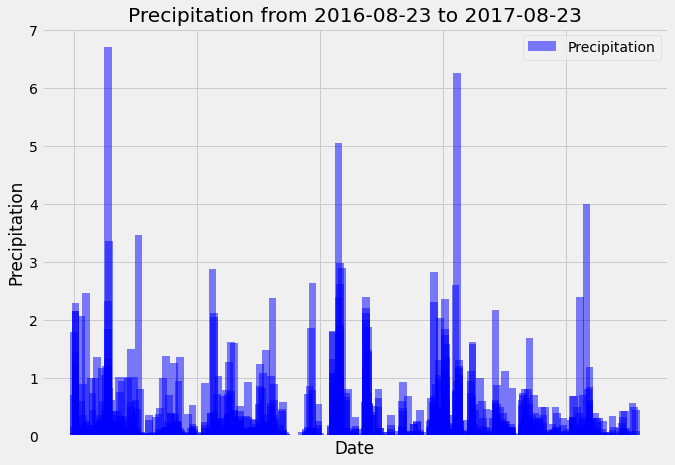

In [16]:
xx = output1_df.index.tolist()
yy = output1_df['prcp'].tolist()

plt.figure(figsize=(10,7))
plt.bar(xx,yy,width = 5 ,color='b', alpha=0.5, align="center",label='Precipitation')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
major_ticks = np.arange(0,400,80)
plt.xticks(major_ticks)

plt.title(f"Precipitation from {year_latestdate} to {most_recent_date[0]}")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.grid(which='major', axis='both', linestyle='-')
plt.legend()
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
output1_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [24]:
# Design a query to calculate the total number stations in the dataset
session.query(station.id).count()

9

In [34]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations=session.query(measurement.station, func.count(measurement.station)).\
group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
activestations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [35]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station='USC00519281'
session.query(func.min(measurement.tobs), func.max(measurement.tobs),func.avg(measurement.tobs)).\
filter(measurement.station==most_active_station).all()

[(54.0, 85.0, 71.66378066378067)]

<AxesSubplot:ylabel='Frequency'>

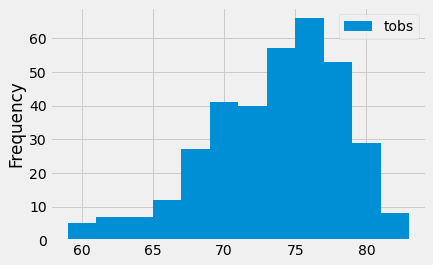

In [44]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tve_month_temp=active_stations[0][0]

output2=session.query(measurement.date,measurement.tobs).\
filter(measurement.date>="2016-08-23").\
filter(measurement.station==active_stations[0][0]).all()
output2_df=pd.DataFrame(output2)
output2_df.plot.hist(bins=12)


# Close session

In [47]:
# Close Session
session.close()